<a href="https://colab.research.google.com/github/NguyenHoangLongVNUK/LSTM_stocks_price/blob/main/Interview_Finpros_deeplearning_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

df = pd.read_csv("/content/drive/MyDrive/FPT.csv")
print(df)
df = df.drop(['Ticker','Open','High','Low','Volume','Open Interest'],axis=1)

      Ticker         Date/Time   Open   High    Low  Close  Volume  \
0        FPT   12/25/2018 9:15  30.89  30.89  30.89  30.89   35410   
1        FPT   12/25/2018 9:16  30.81  30.81  30.81  30.81     190   
2        FPT   12/25/2018 9:17  30.74  30.81  30.74  30.74    1120   
3        FPT   12/25/2018 9:18  30.74  30.74  30.74  30.74    2120   
4        FPT   12/25/2018 9:19  30.74  30.74  30.74  30.74   22500   
...      ...               ...    ...    ...    ...    ...     ...   
97401    FPT  12/22/2020 14:24  58.20  58.20  58.20  58.20   27470   
97402    FPT  12/22/2020 14:25  58.20  58.20  58.20  58.20   14820   
97403    FPT  12/22/2020 14:26  58.20  58.20  58.20  58.20     500   
97404    FPT  12/22/2020 14:29  58.10  58.10  58.10  58.10    2500   
97405    FPT  12/22/2020 14:46  58.10  58.10  58.10  58.10   11170   

       Open Interest  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ... 

In [ ]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

def create_full_time_range(x):
    date = x['Date/Time'].dt.date.iloc[0]
    full_time_range = pd.date_range(start=f'{date} 09:15:00', end=f'{date} 14:46:00', freq='min')
    full_time_range = full_time_range[(full_time_range.time >= pd.to_datetime('9:15').time()) & (full_time_range.time <= pd.to_datetime('11:30').time()) | (full_time_range.time >= pd.to_datetime('13:00').time()) & (full_time_range.time <= pd.to_datetime('14:46').time())]
    return pd.DataFrame({'Date/Time': full_time_range})

full_df = df.groupby(df['Date/Time'].dt.date).apply(create_full_time_range).reset_index(drop=True)

# Kết hợp dữ liệu ban đầu với dữ liệu được tạo ra
result = pd.merge(full_df, df, on='Date/Time', how='left')
# # Điền dữ liệu cho các cột khác
result['Close'] = result['Close'].fillna(method='ffill')
# Lấy dữ liệu cột Close
data = result.iloc[:,[1]].values

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
data= sc.fit_transform(data)


In [ ]:
#Chia data theo ngày
size=243
temp=0
day=[]
dataset=[]
for i in range(len(data)):
  day.append(data[i])
  temp+=1
  if (temp==size):
    temp=0
    dataset.append(day)
    day=[]
dataset=np.asarray(dataset)
dataset=dataset.reshape(len(dataset),size)
print(dataset.shape)

(499, 243)


In [ ]:
# Chia data thành tập train và nhãn theo yêu cầu lấy dữ liệu 7 ngày để dự đoán cho 1 ngày kế tiếp
wd_size=7
h_size=1
X_dataset = []
y_dataset = []
no_of_sample = len(dataset)
for i in range(wd_size, no_of_sample):
    X_dataset.append(dataset[i-wd_size:i])
    y_dataset.append(dataset[i:i+h_size])
X_dataset, y_dataset = np.array(X_dataset), np.array(y_dataset)

X_dataset=X_dataset.reshape(no_of_sample - wd_size,size * wd_size,1)
y_dataset=y_dataset.reshape(no_of_sample - wd_size,size)
print(X_dataset.shape,y_dataset.shape)

(492, 1701, 1) (492, 243)


In [ ]:
# Phân chia tập train, test
train_size = int(len(X_dataset) * 0.8)
test_size = len(X_dataset) - train_size
X_train, X_test = X_dataset[0:train_size,:], X_dataset[train_size:len(X_dataset),:]
y_train, y_test = y_dataset[0:train_size,:], y_dataset[train_size:len(y_dataset),:]
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(393, 1701, 1) (393, 243)
(99, 1701, 1) (99, 243)


In [ ]:
# Xay dung model LSTM
Myfinal = Sequential()
Myfinal.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
Myfinal.add(Dropout(0.2))
Myfinal.add(LSTM(units = 50, return_sequences = True))
Myfinal.add(Dropout(0.2))
Myfinal.add(LSTM(units = 50, return_sequences = True))
Myfinal.add(Dropout(0.2))
Myfinal.add(LSTM(units = 50))
Myfinal.add(Dropout(0.2))
Myfinal.add(Dense(units = size))
Myfinal.compile(optimizer = 'adam', loss = 'mean_squared_error')
Myfinal.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1701, 50)          10400     
                                                                 
 dropout (Dropout)           (None, 1701, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1701, 50)          20200     
                                                                 
 dropout_1 (Dropout)         (None, 1701, 50)          0         
                                                                 
 lstm_2 (LSTM)               (None, 1701, 50)          20200     
                                                                 
 dropout_2 (Dropout)         (None, 1701, 50)          0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
Myfinal.fit(X_train, y_train, epochs = 150, batch_size = 32)
Myfinal.save("Myfinal.h5")

Epoch 1/150
13/13 [==============================] - 60s 4s/step - loss: 0.1981
Epoch 2/150
13/13 [==============================] - 52s 4s/step - loss: 0.0758
Epoch 3/150
13/13 [==============================] - 50s 4s/step - loss: 0.0227
Epoch 4/150
13/13 [==============================] - 49s 4s/step - loss: 0.0132
Epoch 5/150
13/13 [==============================] - 50s 4s/step - loss: 0.0103
Epoch 6/150
13/13 [==============================] - 51s 4s/step - loss: 0.0090
Epoch 7/150
13/13 [==============================] - 49s 4s/step - loss: 0.0083
Epoch 8/150
13/13 [==============================] - 49s 4s/step - loss: 0.0085
Epoch 9/150
13/13 [==============================] - 51s 4s/step - loss: 0.0072
Epoch 10/150
13/13 [==============================] - 50s 4s/step - loss: 0.0065
Epoch 11/150
13/13 [==============================] - 49s 4s/step - loss: 0.0060
Epoch 12/150
13/13 [==============================] - 50s 4s/step - loss: 0.0067
Epoch 13/150
13/13 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predicted_stock_price = Myfinal.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

4/4 [==============================] - 7s 782ms/step


In [ ]:
# print(predicted_stock_price)
print(predicted_stock_price.shape)

(99, 243)


In [ ]:
real_stock_price=sc.inverse_transform(y_test)

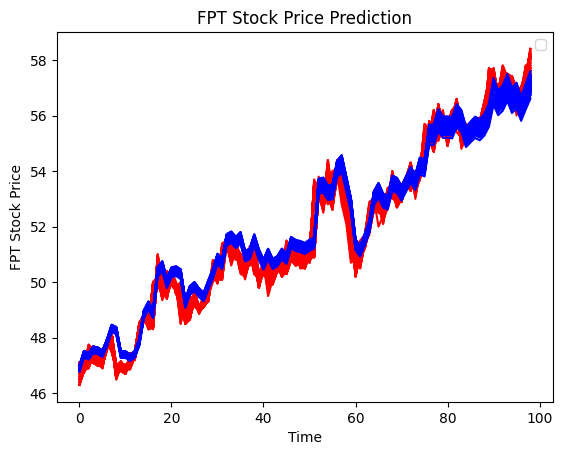

In [ ]:
plt.plot(real_stock_price, color = 'red')
plt.plot(predicted_stock_price, color = 'blue')
# plt.plot(predicted_stock_price - real_stock_price)
plt.title('FPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()

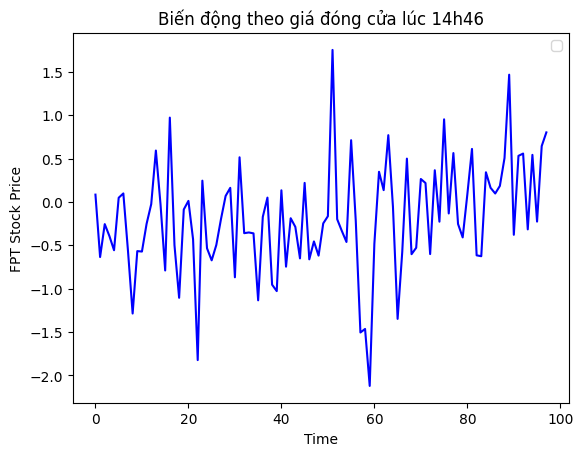

In [ ]:
real=[]
predict=[]
change=[]
for i in range(0,98):
  real.append(real_stock_price[i][242])
  predict.append(predicted_stock_price[i][242])
  change.append(real_stock_price[i][242]-predicted_stock_price[i][242])
# plt.plot(real-predict, color = 'red')
plt.plot(change, color = 'blue')
plt.title('Biến động theo giá đóng cửa lúc 14h46')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()